# EDA After Features Created

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text

from pathlib import Path

from utils import setup_import

setup_import()

from fraud_detection.data.database import get_db_engine

plt.style.use("ggplot")
sns.set_palette("Set2")

engine = get_db_engine()

%load_ext autoreload
%autoreload 2

ROOT: /workspace/fraud-ml-pipeline


In [2]:
sql_file_path = Path("../src/fraud_detection/features/sql/create_feature_transactions.sql")
query_logic = "".join(sql_file_path.read_text().splitlines(keepends=True)[1:])[:-1] # Remove first line and last semicolon

full_query = text(f"""
    {query_logic}
    LIMIT 100000;
    """)

df_features = pd.read_sql(full_query, engine, parse_dates=["trans_ts", "dob"])
df_features.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,tx_in_last_24h,tx_in_last_7d,avg_amt_in_last_24h,avg_amt_in_last_7d,ratio_to_avg_amt_in_last_7d,ratio_to_avg_amt_in_last_24h,avg_amt_historical,amt_ratio_to_avg,category_tx_count,tx_with_same_merch_in_last_1h
0,468-37-7864,60400268763,Elizabeth,Gardner,F,6497 Mclean Corners Suite 365,Sterling Heights,MI,48313,42.6005,...,1,1,59.390,59.390000,1.000000,1.000000,NaN,NaN,0,1
1,468-37-7864,60400268763,Elizabeth,Gardner,F,6497 Mclean Corners Suite 365,Sterling Heights,MI,48313,42.6005,...,2,2,33.860,33.860000,0.246013,0.246013,59.390000,0.140259,1,1
2,468-37-7864,60400268763,Elizabeth,Gardner,F,6497 Mclean Corners Suite 365,Sterling Heights,MI,48313,42.6005,...,1,3,7.510,25.076667,0.299482,1.000000,33.860000,0.221796,2,1
3,468-37-7864,60400268763,Elizabeth,Gardner,F,6497 Mclean Corners Suite 365,Sterling Heights,MI,48313,42.6005,...,2,4,9.965,21.912500,0.566800,1.246362,25.076667,0.495281,3,1
4,468-37-7864,60400268763,Elizabeth,Gardner,F,6497 Mclean Corners Suite 365,Sterling Heights,MI,48313,42.6005,...,1,5,64.030,30.336000,2.110694,1.000000,21.912500,2.922076,4,1


## Distance and Age

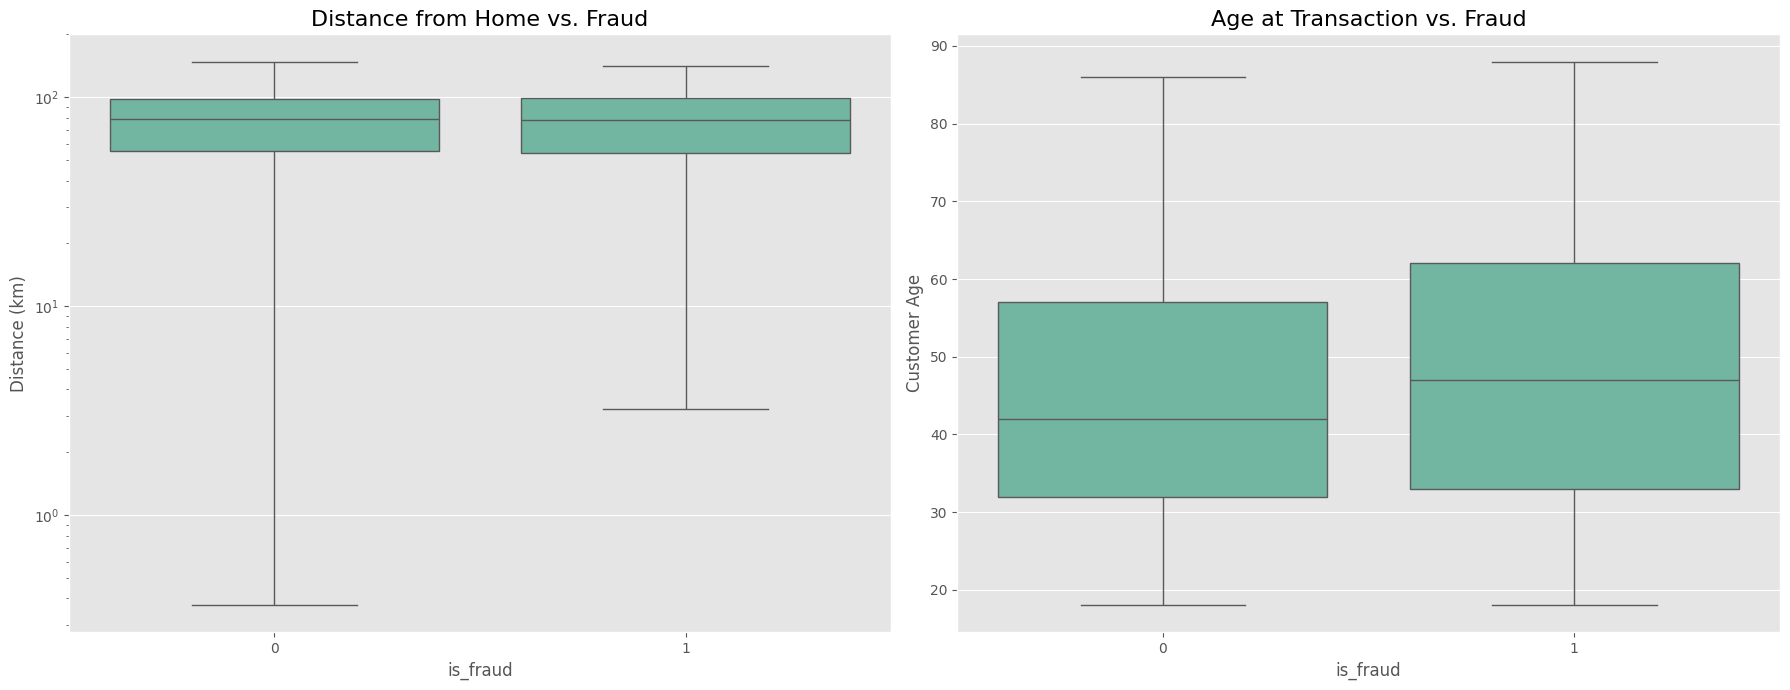

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. 距離 (distance_from_home_km)
sns.boxplot(x='is_fraud', y='distance_from_home_km', data=df_features, ax=axes[0])
axes[0].set_title('Distance from Home vs. Fraud', fontsize=16)
axes[0].set_yscale('log') # y軸を対数スケールにして見やすくする
axes[0].set_xlabel('is_fraud', fontsize=12)
axes[0].set_ylabel('Distance (km)', fontsize=12)

# 2. 年齢 (age_at_transaction)
sns.boxplot(x='is_fraud', y='age_at_tx', data=df_features, ax=axes[1])
axes[1].set_title('Age at Transaction vs. Fraud', fontsize=16)
axes[1].set_xlabel('is_fraud', fontsize=12)
axes[1].set_ylabel('Customer Age', fontsize=12)

plt.tight_layout()
plt.show()

## RFM and Velocity

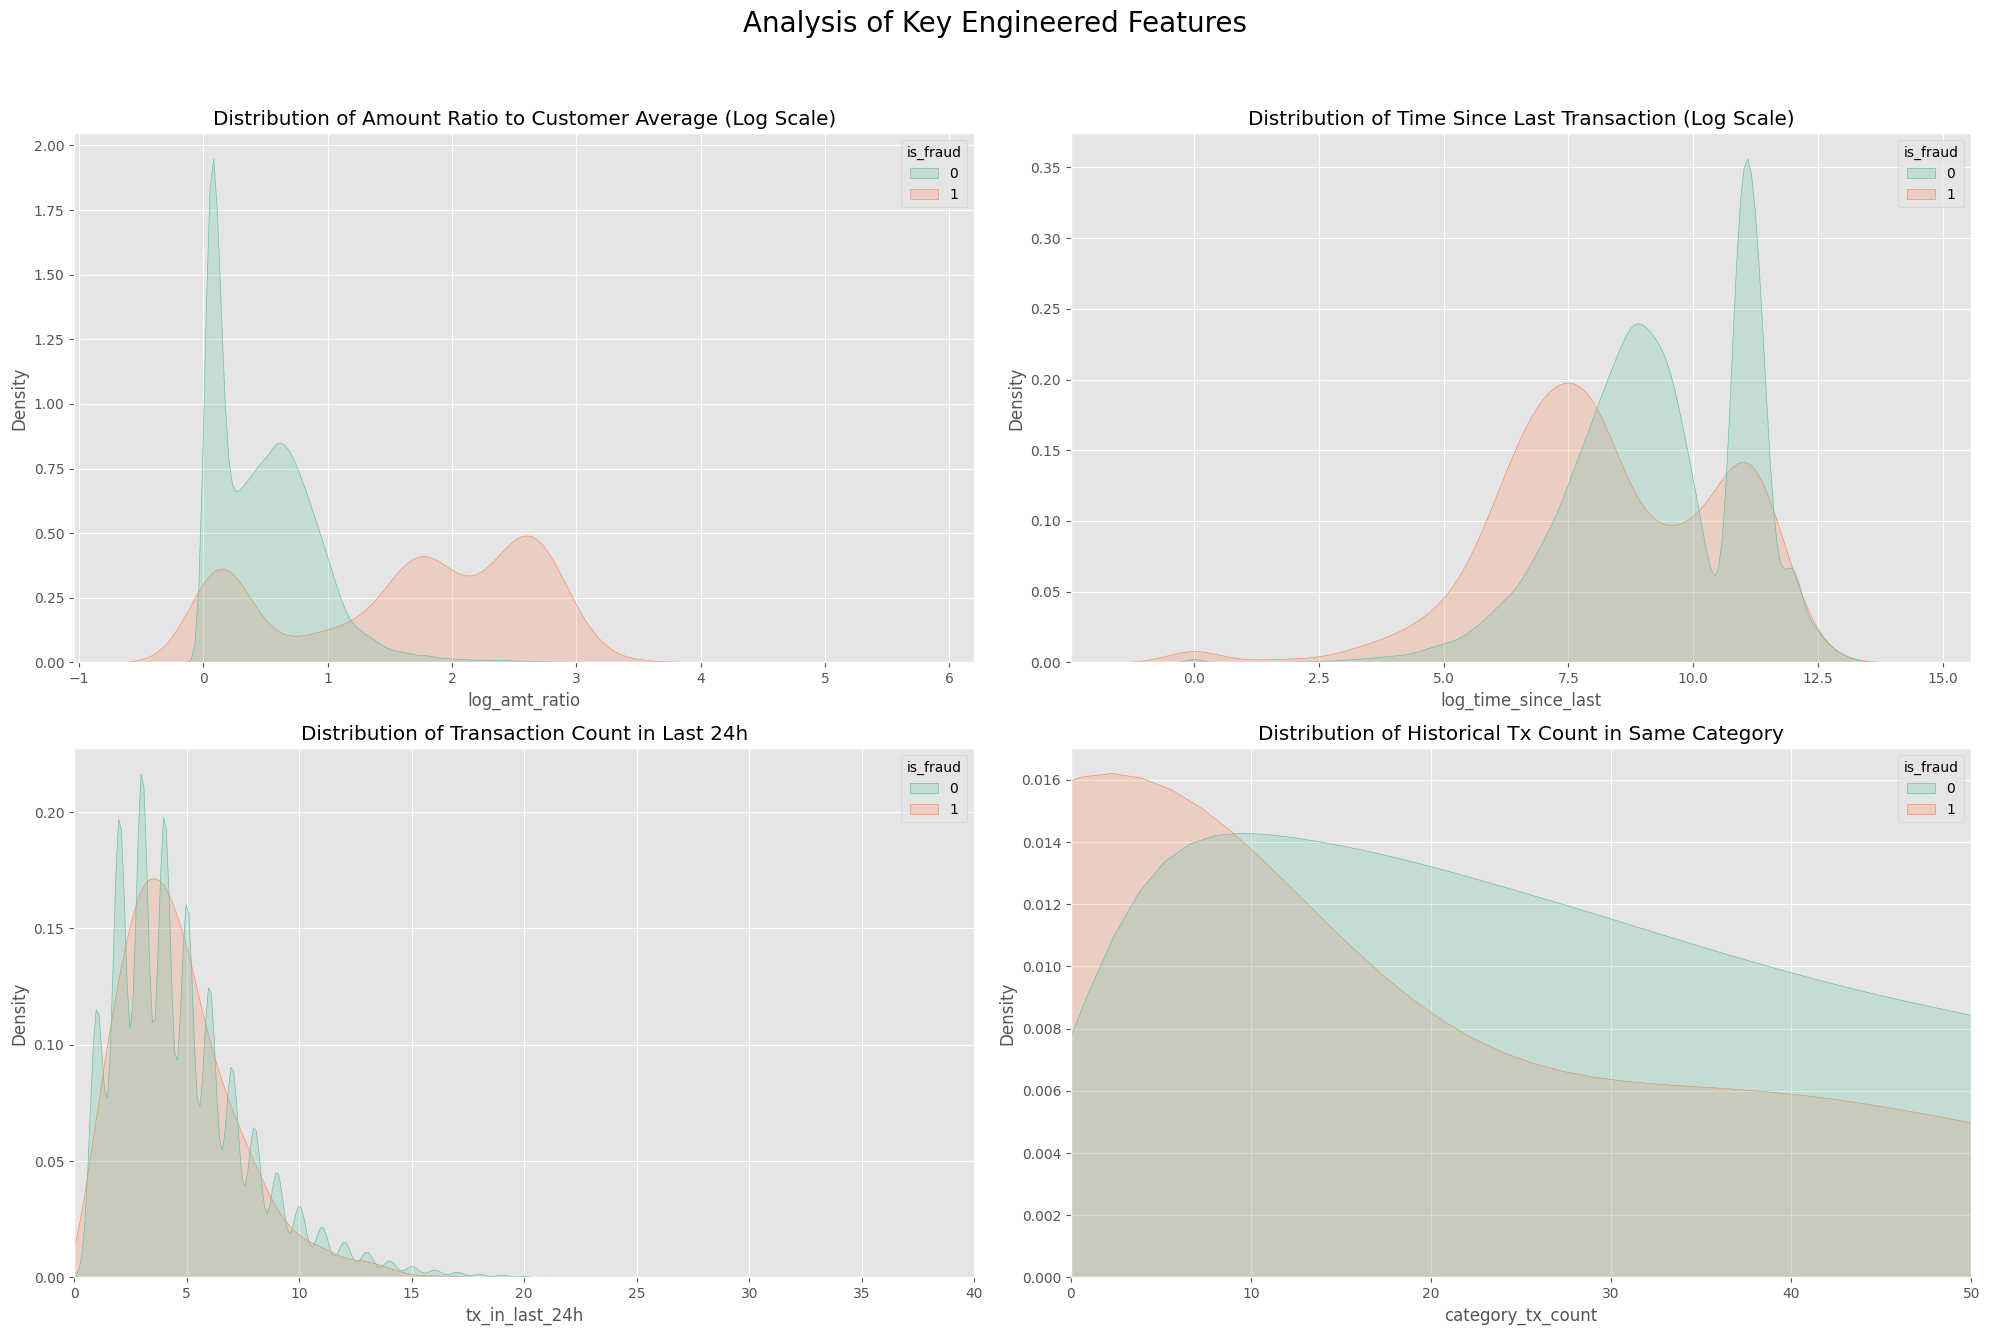

In [8]:
import numpy as np

# --- 残りの主要な特徴量の分布を比較 ---

# 2x2の描画領域を作成
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Analysis of Key Engineered Features', fontsize=20)

# 1. 取引金額の逸脱度 (amt_ratio_to_avg)
# 値が1に近いところに集中するため、対数変換してプロット
df_features['log_amt_ratio'] = np.log1p(df_features['amt_ratio_to_avg'].fillna(0))
sns.kdeplot(data=df_features, x='log_amt_ratio', hue='is_fraud', fill=True, common_norm=False, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Amount Ratio to Customer Average (Log Scale)')

# 2. 直前の取引からの経過時間 (time_since_last_tx_sec)
# こちらも skewed なので対数変換
df_features['log_time_since_last'] = np.log1p(df_features['time_since_last_tx_sec'].fillna(0))
sns.kdeplot(data=df_features, x='log_time_since_last', hue='is_fraud', fill=True, common_norm=False, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Time Since Last Transaction (Log Scale)')

# 3. 過去24時間の取引回数 (tx_in_last_24h)
sns.kdeplot(data=df_features, x='tx_in_last_24h', hue='is_fraud', fill=True, common_norm=False, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Transaction Count in Last 24h')
axes[1, 0].set_xlim(0, 40) # 見やすいようにx軸の範囲を絞る

# 4. 同カテゴリでの過去の取引回数 (category_tx_count)
sns.kdeplot(data=df_features, x='category_tx_count', hue='is_fraud', fill=True, common_norm=False, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Historical Tx Count in Same Category')
axes[1, 1].set_xlim(0, 50) # 見やすいようにx軸の範囲を絞る

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()